# General Room Simulator

In [156]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ortools.linear_solver import pywraplp as OR
import itertools

In [157]:

def __miset(nodes,edges,solver,time_limit):
    # define model
    m = OR.Solver('maxIndSet', solver)
    m.set_time_limit(60000*time_limit)
    # decision variables
    x = {} # node i is in the maximal independent set is 1, else 0
    for i in nodes:
        x[i] = m.IntVar(0, 1, ('%s' % (i)))
        
    # objective function
    m.Maximize(sum(x[i] for i in nodes))

    # subject to: no more than 1 node from an edge
    for edge in edges:
        m.Add(x[edge[0]] + x[edge[1]] <= 1)

    m.Solve()

    sol = {}
    for i in nodes:
        sol.update( {x[i].name() : x[i].solution_value()} )
        
    return(sol)

In [179]:
%%time
x_max = 45
y_max = 70

social_distancing_radius = 6
stepsize = social_distancing_radius/10


x_range = list(np.arange(0,x_max,step = stepsize))
y_range = list(np.arange(0,y_max,step = stepsize))

grid = list(itertools.product(x_range,y_range))
room = pd.DataFrame(grid,columns = ['x','y'])
edgelist = []
for i in range(len(grid)):
        for j in range(len(grid)):
            if (i != j):
                dist = np.sqrt((grid[i][0] - grid[j][0])**2 + (grid[i][1] - grid[j][1])**2)
                if (dist <= social_distancing_radius):
                    edgelist.append((i,j)) 

nodes=[]
for i in range(len(grid)):
    nodes.append(i)



CPU times: user 2min 14s, sys: 237 ms, total: 2min 14s
Wall time: 2min 15s


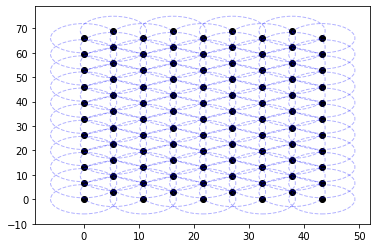

CPU times: user 6min 31s, sys: 5.6 s, total: 6min 37s
Wall time: 6min 39s


In [180]:
%%time

sol = __miset(nodes, edgelist, OR.Solver.SCIP_MIXED_INTEGER_PROGRAMMING,6)
room['in_solution'] = list(sol.values())

plt.figure()
plt.scatter(room[room['in_solution'] == 1]['x'],room[room['in_solution'] == 1]['y'], color = 'black', label = 'Available Seat')
ax = plt.gca()
for i,row in room[room['in_solution'] == 1].iterrows():
    circle = plt.Circle((row['x'], row['y']), social_distancing_radius , color='blue', fill = None, ls = 'dashed',alpha = 0.3)
    ax.add_patch(circle)
plt.show()

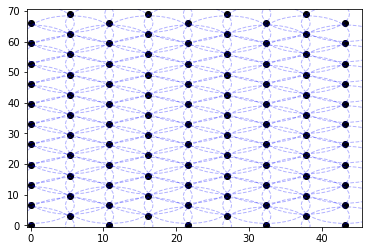

Available Seats: 99
Distance Between Seats: 6


In [181]:
buffer = 0.5
plt.figure()
plt.scatter(room[room['in_solution'] == 1]['x'],room[room['in_solution'] == 1]['y'], color = 'black', label = 'Available Seat')
ax = plt.gca()
for i,row in room[room['in_solution'] == 1].iterrows():
    circle = plt.Circle((row['x'], row['y']), social_distancing_radius , color='blue', fill = None, ls = 'dashed',alpha = 0.3)
    ax.add_patch(circle)

plt.xlim((-buffer,x_max+buffer))
plt.ylim((-buffer,y_max+buffer))
plt.show()
print('Available Seats: ' + str(int(sum(room['in_solution']))))
print('Distance Between Seats: '  +str(int(social_distancing_radius)))


In [1]:
import pandas as pd
import sys
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pickle
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import seaborn as sns
import gc
import itertools
import random
import math
from matplotlib.ticker import FormatStrFormatter
import ray
import shapley
sys.path.append('../')



In [12]:
class_risk_params = {
    'prevalence': 5*10**(-4),
    'vax_effectiveness': .715,
    'sensitivity': 0.6,
    'mask_efficacy': 0.8
}


aerosol_params = {
    'inhale_air_rate': 6.8,
    'dose_response_constant': 1440,
    
    'nominal_breathe_virus_emitted_hourly': 3300,# corresponding to 10^8 copies / mL
    'nominal_talk_virus_emitted_hourly' : 27300,
    'nominal_sing_virus_emitted_hourly' : 330000,
    'nominal_heavy_breathe_virus_emitted_hourly': 3300*15,

    'viral_load_distribution': [0.12, 0.22, 0.3, 0.23, 0.103, 0.0236, 0.0034] # over orders of magnitude from 10^5 to 10^11
}

"""
Difference of sets
"""
def Diff(li1, li2):
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
    return li_dif

"""
Biased coin flipper
"""
def flip(p):
    return 1 if random.random() < p else 0


def simulate_class_single_aerosol(room,vax_infected, unvax_infected, time,alpha,masked_status,class_type,room_vol,N,pixels_per_foot, air_exchanges_per_hour):
    room = room.reset_index()
    vax_infect_id = random.sample(list(room[room['seating'] == 'V']['index'].values), vax_infected)
    unvax_infect_id = random.sample(list(room[room['seating'] == 'U']['index'].values), unvax_infected)
    infected = room[room['index'].isin(np.append(vax_infect_id,unvax_infect_id))]
    uninfected = room[ (~room['index'].isin(np.append(vax_infect_id,unvax_infect_id))) & \
                      (room['seating'] != 'E')  ]
    
    if vax_infected == 1:
        source_status = 'V'
    elif unvax_infected == 1:
        source_status = 'U'
    infected_x = infected['x']
    infected_y = infected['y']
    
    unvax_aerosol_risk = (1/air_exchanges_per_hour)*generate_aerosol_risk(room_vol, vax_infected, unvax_infected, time, masked_status, class_type, params = aerosol_params)
    
    p_infections = []
    for i,row in uninfected.iterrows():
        
        x = row['x']
        y = row['y']
        v_infect = [x-infected_x,y - infected_y]
        v_vert = [0,10000]
        dot = v_infect[1]*v_vert[1]
        mag1 = 10000
        mag2 = np.sqrt((x-infected_x)**2+(y - infected_y)**2)
        theta =  math.acos(dot/(mag1*mag2))*180/math.pi
        
        susceptible_status = row['seating']
        
        susceptible_aerosol_risk = unvax_aerosol_risk 
        
        if susceptible_status == 'V':
            susceptible_aerosol_risk = susceptible_aerosol_risk * (1-class_risk_params['vax_effectiveness'])
        
        if masked_status == True:
            if susceptible_status == 'U':
                susceptible_aerosol_risk = susceptible_aerosol_risk * class_risk_params['mask_efficacy']
       
        if theta < 90 + alpha:
       
            dist = np.sqrt((infected_x-x)**2+(infected_y-y)**2)
            p = updated_distance_to_prob(dist,susceptible_status,source_status,masked_status,time,pixels_per_foot)
            p = max(p,susceptible_aerosol_risk)
            p_infections.append(p)
            
        else:
            
            p_infections.append(susceptible_aerosol_risk)
            
    return np.sum(p_infections),unvax_aerosol_risk

def updated_distance_to_prob(d,susceptible_status,source_status,masked_status,time,pixels_per_foot): 
    
    d = d/pixels_per_foot*0.3048
    susceptible_const = 1
    source_const = 1
    masked_const_source = 1
    masked_const_susceptible = 1
    if susceptible_status == 'V':
        susceptible_const = 1 - class_risk_params['vax_effectiveness'] 
    if source_status == 'V':
        source_const = 0.29 
        
    if masked_status == True:
        
        if source_status == 'U':
            masked_const_source = class_risk_params['mask_efficacy']
        if susceptible_status == 'U':
            masked_const_susceptible = class_risk_params['mask_efficacy']
        
        
    prob = 2.4*susceptible_const*masked_const_susceptible *masked_const_source *(1-np.exp(-1 *  source_const * 0.0135 *time * (-0.1819*np.log(d)+0.43276)/d))
    
    prob = float(prob)
    return max(prob,0)

def generate_aerosol_risk(room_vol, vax_infected, unvax_infected, time, masked_status, class_type, params = aerosol_params):
    
    if class_type == 'breathe':
        v = params['nominal_breathe_virus_emitted_hourly'] 
    elif class_type == 'speak':
        v = params['nominal_talk_virus_emitted_hourly'] 
    elif class_type == 'sing':
        v = params['nominal_sing_virus_emitted_hourly'] 
    elif class_type == 'heavy_breathe':
        v = params['nominal_heavy_breathe_virus_emitted_hourly']
    elif class_type == 'no_aerosol':
        return 0
    
    hourly_virus_array = np.array([v/1000, v/100, v/10, v, v*10, v*100, v*1000])
    dose_array = hourly_virus_array * params['inhale_air_rate'] / room_vol
    
    if masked_status == True:
        if unvax_infected == 1:
            dose_array = dose_array * class_risk_params['mask_efficacy']
    
    if vax_infected == 1:
        dose_array = dose_array * 0.29 
  
    effective_dose_array = dose_array / params['dose_response_constant']

    unvax_susceptible_risk_array = 1 - np.exp(-effective_dose_array)
    unvax_susceptible_risk = np.dot(unvax_susceptible_risk_array, np.array(params['viral_load_distribution']))
    unvax_susceptible_risk_over_time = 2.4*unvax_susceptible_risk * time

    return unvax_susceptible_risk_over_time #risk for unvax + no mask

In [13]:
def generate_clumpy_plan(N,p,room, clump_size = 3):
    Nvax = round(N*p)
    Nunvax = N-Nvax
    room = room.drop('UnvaxSpot',axis = 1).reset_index()
    grid = room.copy()
    grid['seating'] = 'E'
    
    if Nunvax > 0:
        clump_size = min(clump_size,Nunvax)
        num_clumps = math.floor(Nunvax/clump_size)
        remainder = Nunvax - num_clumps*clump_size
        clump = 0
        while clump < (num_clumps):
            ind1 = np.random.choice(room['index'].values,replace = False)
            grid['seating'].loc[grid['index'] == ind1] = 'U'
            room = room.drop(ind1, axis = 0)
            x_temp = grid['x'].loc[grid['index'] == ind1].values[0]
            y_temp = grid['y'].loc[grid['index'] == ind1].values[0]  
            temp = room.copy()
            temp['dist_infected'] = ((temp['x'] -x_temp) ** 2 + (temp['y'] - y_temp) ** 2) ** 0.5
            temp = temp.sort_values('dist_infected', ascending = True).head(clump_size-1)
            grid['seating'].loc[grid['index'].isin(temp['index'].values)] = 'U'
            room = room.drop(temp['index'].values, axis = 0)
            clump = clump + 1
        remainder_ind = np.random.choice(grid['index'].loc[grid['seating'] == 'E'],remainder,replace = False)
        grid['seating'].loc[grid['index'].isin(remainder_ind)] = 'U'

    vax_ind = np.random.choice(grid['index'].loc[grid['seating'] == 'E'],Nvax,replace = False) 
    grid['seating'].loc[grid['index'].isin(vax_ind)] = 'V'
    
    return grid

def generate_random_plan(N,p,room):
    Nvax = round(N*p)
    Nunvax = N-Nvax
    
    room = room.drop('UnvaxSpot',axis = 1)
    grid = room.copy()
    grid = grid.reset_index()
    temp = list(np.append(np.append(np.repeat('V',Nvax),np.repeat('U',Nunvax)),np.repeat('E',len(grid)-Nvax-Nunvax)))
    random.shuffle(temp)
    grid['seating'] = temp
    return grid


# Load Room Plans

([], [])

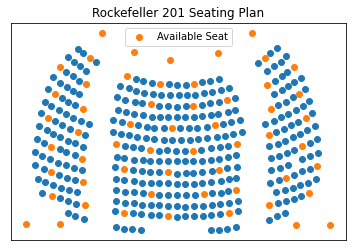

In [25]:
# Big Room
with open("../Data/rk201.pickle" , 'rb') as handle:
    layout = pickle.load(handle)

big_pixels_per_foot = (2074-1575)/20
big_volume = 1684283

x_coord = [i.x for i in layout['Middles']]
y_coord = [i.y for i in layout['Middles']]
room = pd.DataFrame(np.column_stack((x_coord,y_coord)), columns = ['x','y'])
room['UnvaxSpot'] = layout['In Solution']



FA2020room = room.copy()
FA2020room['label'] = FA2020room.index

#label of seats used in 2020
indicies = [282,283,284,285, 286,287,288,289,290,365,238,270,273,110,362,358,227,222,260,104,100,348,352,207,20,250,89,
           93,76,80,189,193,172,163,339,334,321,168,25,2,61,65,51,14,121,138,149,308,312,299,294,144,124,34,40,36]
FA2020room['UnvaxSpot'] = 0
FA2020room['UnvaxSpot'].iloc[indicies] = 1
FA2020room.drop('label', axis =1,inplace = True)
FA2020room['seating'] = 'E'
FA2020room['seating'].loc[FA2020room['UnvaxSpot'] == 1] = 'U'
plt.figure()
plt.scatter(FA2020room[FA2020room['UnvaxSpot'] == 0]['x'],FA2020room[FA2020room['UnvaxSpot'] == 0]['y'])
plt.scatter(FA2020room[FA2020room['UnvaxSpot'] == 1]['x'],FA2020room[FA2020room['UnvaxSpot'] == 1]['y'], label = 'Available Seat')
plt.title('Rockefeller 201 Seating Plan')
FA2020_subset = FA2020room[FA2020room['UnvaxSpot']==1 ].reset_index().drop('index', axis = 1)
big_plan = FA2020_subset.copy()
plt.legend()
plt.xticks([])
plt.yticks([])
#print([big_pixels_per_foot,big_volume,big_plan])

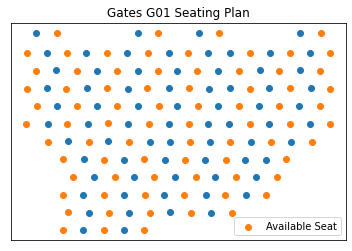

In [15]:
with open("../Data/gtsg01.pickle" , 'rb') as handle:
    layout = pickle.load(handle)

medium_pixels_per_foot = (2834-2082)/20
medium_volume = 1087931

x_coord = [-i.x +3000 for i in layout['Middles']]
y_coord = [-i.y +3000 for i in layout['Middles']]
room = pd.DataFrame(np.column_stack((x_coord,y_coord)), columns = ['x','y'])
room['UnvaxSpot'] = layout['In Solution']
room_subset = room[room['UnvaxSpot'] == 1].reset_index().drop('index',axis = 1)
medium_plan = room_subset.copy()

plt.scatter(room[room['UnvaxSpot'] == 0]['x'],room[room['UnvaxSpot'] == 0]['y'])
plt.scatter(room[room['UnvaxSpot'] == 1]['x'],room[room['UnvaxSpot'] == 1]['y'], label = 'Available Seat')
plt.title('Gates G01 Seating Plan')
plt.xticks([])
plt.yticks([])
plt.legend()

([], [])

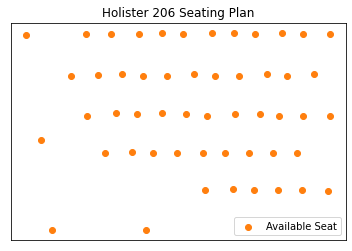

In [16]:
# Small Room
with open("../Data/hls206.pickle" , 'rb') as handle:
    layout = pickle.load(handle)

small_pixels_per_foot = (2014-1260)/15
small_volume = 222004

x_coord = [i.x for i in layout['Middles']]
y_coord = [i.y for i in layout['Middles']]
room = pd.DataFrame(np.column_stack((x_coord,y_coord)), columns = ['x','y'])
room['UnvaxSpot'] = layout['In Solution']


small_plan = room.copy()


plt.figure()
plt.scatter(small_plan[small_plan['UnvaxSpot'] == 0]['x'],small_plan[small_plan['UnvaxSpot'] == 0]['y'])
plt.scatter(small_plan[small_plan['UnvaxSpot'] == 1]['x'],small_plan[small_plan['UnvaxSpot'] == 1]['y'],  label = 'Available Seat')
plt.title('Holister 206 Seating Plan')
plt.legend()
plt.xticks([])
plt.yticks([])

#print([small_pixels_per_foot,small_volume,small_plan])

V    35
U    15
E     6
Name: seating, dtype: int64
V    35
E    27
U    15
Name: seating, dtype: int64
V    35
U    15
E     2
Name: seating, dtype: int64
V    35
U    15
E     6
Name: seating, dtype: int64
V    35
E    27
U    15
Name: seating, dtype: int64
V    35
U    15
E     2
Name: seating, dtype: int64


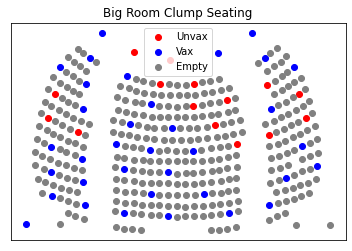

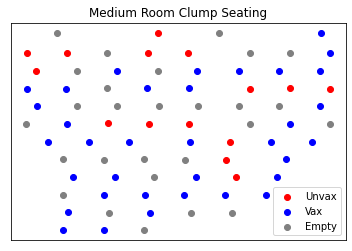

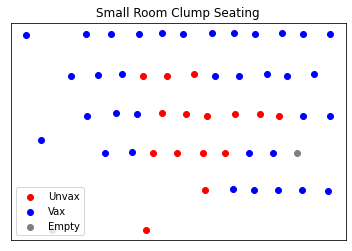

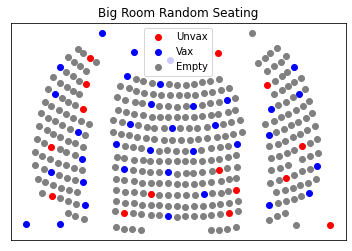

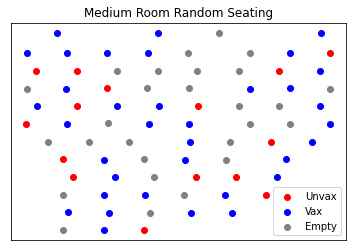

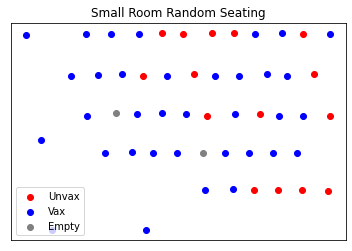

In [17]:
grid = generate_clumpy_plan(50,.7,big_plan,3)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.scatter(FA2020room[FA2020room['UnvaxSpot'] == 0]['x'],FA2020room[FA2020room['UnvaxSpot'] == 0]['y'],color = 'grey')
plt.title('Big Room '+ 'Clump Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())

grid = generate_clumpy_plan(50,.7,medium_plan,3)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.title('Medium Room '+ 'Clump Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())


grid = generate_clumpy_plan(50,.7,small_plan,3)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.title('Small Room '+ 'Clump Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())

grid = generate_random_plan(50,.7,big_plan)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.scatter(FA2020room[FA2020room['UnvaxSpot'] == 0]['x'],FA2020room[FA2020room['UnvaxSpot'] == 0]['y'],color = 'grey')
plt.title('Big Room '+ 'Random Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())

grid = generate_random_plan(50,.7,medium_plan)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.title('Medium Room '+ 'Random Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())

grid = generate_random_plan(50,.7,small_plan)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.title('Small Room '+ 'Random Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())

### Simulator

In [18]:
#General Parameters
seating_function = generate_clumpy_plan
p_range = [0.5,0.6,0.7,0.8,0.9,1.0]

N = 50
angle = 15
time = 1


class_risk_params = {
    'prevalence': 5*10**(-4),
    'vax_effectiveness': .715,
    'sensitivity': 0.6,
    'mask_efficacy': 0.4
}


aerosol_params = {
    'inhale_air_rate': 6.8,
    'dose_response_constant': 1440,
    
    'nominal_breathe_virus_emitted_hourly': 3300,# corresponding to 10^8 copies / mL
    'nominal_talk_virus_emitted_hourly' : 27300,
    'nominal_sing_virus_emitted_hourly' : 330000,
    'nominal_heavy_breathe_virus_emitted_hourly': 3300*15,

    'viral_load_distribution': [0.12, 0.22, 0.3, 0.23, 0.103, 0.0236, 0.0034] # over orders of magnitude from 10^5 to 10^11
}




args = [[]]



args = [
    
    [False,big_plan,big_volume,big_pixels_per_foot,'no_aerosol',2,'distanced_outside_nomask'],
    [True,big_plan,big_volume,big_pixels_per_foot,'no_aerosol',2,'distanced_outside_unvaxmask'],
    
    [False,big_plan,big_volume,big_pixels_per_foot,'breathe',2,'distanced_breathe_nomask_2x'],
    [False,big_plan,big_volume,big_pixels_per_foot,'breathe',4,'distanced_breathe_nomask_4x'],
    
    [True,big_plan,big_volume,big_pixels_per_foot,'breathe',2,'distanced_breathe_unvaxmask_2x'],
    [True,big_plan,big_volume,big_pixels_per_foot,'breathe',4,'distanced_breathe_unvaxmask_4x'],
    
    [False,big_plan,big_volume,big_pixels_per_foot,'speak',2,'distanced_speak_nomask_2x'],
    [False,big_plan,big_volume,big_pixels_per_foot,'speak',4,'distanced_speak_nomask_4x'],
    
    [True,big_plan,big_volume,big_pixels_per_foot,'speak',2,'distanced_speak_unvaxmask_2x'],
    [True,big_plan,big_volume,big_pixels_per_foot,'speak',4,'distanced_speak_unvaxmask_4x'],
    
    
    [False,big_plan,big_volume,big_pixels_per_foot,'sing',2,'distanced_sing_nomask_2x'],  ###
    [False,big_plan,big_volume,big_pixels_per_foot,'sing',4,'distanced_sing_nomask_4x'], ###
    
    [True,big_plan,big_volume,big_pixels_per_foot,'sing',2,'distanced_sing_unvaxmask_2x'], ###
    [True,big_plan,big_volume,big_pixels_per_foot,'sing',4,'distanced_sing_unvaxmask_4x'], ###
    
    
    #############################################################################################
    
    [False,medium_plan,medium_volume,medium_pixels_per_foot,'no_aerosol',2,'moderate_outside_nomask'],
    [True,medium_plan,medium_volume,medium_pixels_per_foot,'no_aerosol',2,'moderate_outside_unvaxmask'],
    
    [False,medium_plan,medium_volume,medium_pixels_per_foot,'breathe',2,'moderate_breathe_nomask_2x'],
    [False,medium_plan,medium_volume,medium_pixels_per_foot,'breathe',4,'moderate_breathe_nomask_4x'],
    
    [True,medium_plan,medium_volume,medium_pixels_per_foot,'breathe',2,'moderate_breathe_unvaxmask_2x'],
    [True,medium_plan,medium_volume,medium_pixels_per_foot,'breathe',4,'moderate_breathe_unvaxmask_4x'],
    
    [False,medium_plan,medium_volume,medium_pixels_per_foot,'speak',2,'moderate_speak_nomask_2x'],
    [False,medium_plan,medium_volume,medium_pixels_per_foot,'speak',4,'moderate_speak_nomask_4x'],
    
    [True,medium_plan,medium_volume,medium_pixels_per_foot,'speak',2,'moderate_speak_unvaxmask_2x'],
    [True,medium_plan,medium_volume,medium_pixels_per_foot,'speak',4,'moderate_speak_unvaxmask_4x'],
    
    
    [False,medium_plan,medium_volume,medium_pixels_per_foot,'sing',2,'moderate_sing_nomask_2x'],  ###
    [False,medium_plan,medium_volume,medium_pixels_per_foot,'sing',4,'moderate_sing_nomask_4x'], ###
    
    [True,medium_plan,medium_volume,medium_pixels_per_foot,'sing',2,'moderate_sing_unvaxmask_2x'], ###
    [True,medium_plan,medium_volume,medium_pixels_per_foot,'sing',4,'moderate_sing_unvaxmask_4x'], ###
    
    
    
    #############################################################################################
    
    [False,small_plan,small_volume,small_pixels_per_foot,'no_aerosol',2,'dense_outside_nomask'],
    [True,small_plan,small_volume,small_pixels_per_foot,'no_aerosol',2,'dense_outside_unvaxmask'],
    
    [False,small_plan,small_volume,small_pixels_per_foot,'breathe',2,'dense_breathe_nomask_2x'],
    [False,small_plan,small_volume,small_pixels_per_foot,'breathe',4,'dense_breathe_nomask_4x'],
    
    [True,small_plan,small_volume,small_pixels_per_foot,'breathe',2,'dense_breathe_unvaxmask_2x'],
    [True,small_plan,small_volume,small_pixels_per_foot,'breathe',4,'dense_breathe_unvaxmask_4x'],
    
    [False,small_plan,small_volume,small_pixels_per_foot,'speak',2,'dense_speak_nomask_2x'],
    [False,small_plan,small_volume,small_pixels_per_foot,'speak',4,'dense_speak_nomask_4x'],
    
    [True,small_plan,small_volume,small_pixels_per_foot,'speak',2,'dense_speak_unvaxmask_2x'],
    [True,small_plan,small_volume,small_pixels_per_foot,'speak',4,'dense_speak_unvaxmask_4x'],
    
    
    [False,small_plan,small_volume,small_pixels_per_foot,'sing',2,'dense_sing_nomask_2x'],  ###
    [False,small_plan,small_volume,small_pixels_per_foot,'sing',4,'dense_sing_nomask_4x'], ###
    
    [True,small_plan,small_volume,small_pixels_per_foot,'sing',2,'dense_sing_unvaxmask_2x'], ###
    [True,small_plan,small_volume,small_pixels_per_foot,'sing',4,'dense_sing_unvaxmask_4x'], ###
    
    
  
       ]



In [19]:
@ray.remote
def parallel_wrapper(p):
    trial = 0
    results = []
    results_aerosol = []
    while trial < 500:
        grid = seating_function(N,p,room)
        p_generate = (1-class_risk_params['vax_effectiveness'])*p/(1-class_risk_params['vax_effectiveness']*p)
        ind = flip(p_generate)
        if sum(grid['seating'] == 'V') == 0:
            ind = 0
        elif sum(grid['seating'] == 'U') == 0:
            ind = 1
        
        infect,aerosol = simulate_class_single_aerosol(grid,ind, 1-ind, time,angle,masked_status,class_type,room_vol,N,pixels_per_foot,air_exchanges_per_hour)
        results.append(infect)
        results_aerosol.append(aerosol)
        trial = trial + 1
    return [p,np.mean(results),np.std(results), np.mean(results_aerosol)]

In [20]:
import warnings
warnings.filterwarnings("ignore")
final_results = {}
for arg in args:
    print(arg[-1])
    masked_status = arg[0]
    room = arg[1]
    room_vol = arg[2]
    pixels_per_foot = arg[3]
    class_type = arg[4]
    air_exchanges_per_hour = arg[5]
    label = arg[6]
    
    
    ray.shutdown()
    ray.init(log_to_driver=False)
    result_ids = []
    for p in p_range:
        result_ids.append(parallel_wrapper.remote(p))    
    results = ray.get(result_ids)  
    ray.shutdown()
    results = pd.DataFrame(results, columns = ['p','mean','std','unvax_aerosol'])
    final_results[label] = results
    gc.collect()

distanced_outside_nomask


2021-08-15 13:02:06,337	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


distanced_outside_unvaxmask


2021-08-15 13:03:08,951	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


distanced_breathe_nomask_2x


2021-08-15 13:04:13,713	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


distanced_breathe_nomask_4x


2021-08-15 13:05:19,052	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


distanced_breathe_unvaxmask_2x


2021-08-15 13:06:22,720	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


distanced_breathe_unvaxmask_4x


2021-08-15 13:07:28,865	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


distanced_speak_nomask_2x


2021-08-15 13:08:31,647	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


distanced_speak_nomask_4x


2021-08-15 13:09:32,406	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


distanced_speak_unvaxmask_2x


2021-08-15 13:10:33,348	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


distanced_speak_unvaxmask_4x


2021-08-15 13:11:33,564	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


distanced_sing_nomask_2x


2021-08-15 13:12:34,127	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


distanced_sing_nomask_4x


2021-08-15 13:13:36,739	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


distanced_sing_unvaxmask_2x


2021-08-15 13:14:37,750	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


distanced_sing_unvaxmask_4x


2021-08-15 13:15:38,447	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_outside_nomask


2021-08-15 13:16:41,051	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_outside_unvaxmask


2021-08-15 13:17:41,174	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_breathe_nomask_2x


2021-08-15 13:18:41,733	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_breathe_nomask_4x


2021-08-15 13:21:22,618	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-15 13:21:24,081	WARNING worker.py:1189 -- The agent on node Brians-MBP.attlocal.net failed with the following error:
Traceback (most recent call last):
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 354, in <module>
    loop.run_until_complete(agent.run())
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 616, in run_until_complete
    return future.result()
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 144, in run
    modules = self._load_modules()
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 98, in _load_modules
    c = cls(self)
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/modules/reporter/reporter_agent.py", line 148, in __init__
    self._metrics_ag

2021-08-15 13:21:35,138	WARNING worker.py:1189 -- The agent on node Brians-MBP.attlocal.net failed with the following error:
Traceback (most recent call last):
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 354, in <module>
    loop.run_until_complete(agent.run())
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 616, in run_until_complete
    return future.result()
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 144, in run
    modules = self._load_modules()
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 98, in _load_modules
    c = cls(self)
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/modules/reporter/reporter_agent.py", line 148, in __init__
    self._metrics_agent = MetricsAgent(dashboard_agent.metrics_export_port)
  File "/Users/brianliu/opt/anaconda3/lib

2021-08-15 13:21:45,936	WARNING worker.py:1189 -- The agent on node Brians-MBP.attlocal.net failed with the following error:
Traceback (most recent call last):
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 354, in <module>
    loop.run_until_complete(agent.run())
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 616, in run_until_complete
    return future.result()
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 144, in run
    modules = self._load_modules()
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 98, in _load_modules
    c = cls(self)
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/modules/reporter/reporter_agent.py", line 148, in __init__
    self._metrics_agent = MetricsAgent(dashboard_agent.metrics_export_port)
  File "/Users/brianliu/opt/anaconda3/lib

2021-08-15 13:21:57,320	WARNING worker.py:1189 -- The agent on node Brians-MBP.attlocal.net failed with the following error:
Traceback (most recent call last):
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 354, in <module>
    loop.run_until_complete(agent.run())
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 616, in run_until_complete
    return future.result()
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 144, in run
    modules = self._load_modules()
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 98, in _load_modules
    c = cls(self)
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/modules/reporter/reporter_agent.py", line 148, in __init__
    self._metrics_agent = MetricsAgent(dashboard_agent.metrics_export_port)
  File "/Users/brianliu/opt/anaconda3/lib

2021-08-15 13:22:08,218	WARNING worker.py:1189 -- The agent on node Brians-MBP.attlocal.net failed with the following error:
Traceback (most recent call last):
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 354, in <module>
    loop.run_until_complete(agent.run())
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 616, in run_until_complete
    return future.result()
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 144, in run
    modules = self._load_modules()
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 98, in _load_modules
    c = cls(self)
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/modules/reporter/reporter_agent.py", line 148, in __init__
    self._metrics_agent = MetricsAgent(dashboard_agent.metrics_export_port)
  File "/Users/brianliu/opt/anaconda3/lib

2021-08-15 13:22:19,239	WARNING worker.py:1189 -- The agent on node Brians-MBP.attlocal.net failed with the following error:
Traceback (most recent call last):
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 354, in <module>
    loop.run_until_complete(agent.run())
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 616, in run_until_complete
    return future.result()
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 144, in run
    modules = self._load_modules()
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 98, in _load_modules
    c = cls(self)
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/modules/reporter/reporter_agent.py", line 148, in __init__
    self._metrics_agent = MetricsAgent(dashboard_agent.metrics_export_port)
  File "/Users/brianliu/opt/anaconda3/lib

2021-08-15 13:22:28,504	WARNING worker.py:1189 -- The agent on node Brians-MBP.attlocal.net failed with the following error:
Traceback (most recent call last):
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 354, in <module>
    loop.run_until_complete(agent.run())
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 616, in run_until_complete
    return future.result()
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 144, in run
    modules = self._load_modules()
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 98, in _load_modules
    c = cls(self)
  File "/Users/brianliu/opt/anaconda3/lib/python3.8/site-packages/ray/new_dashboard/modules/reporter/reporter_agent.py", line 148, in __init__
    self._metrics_agent = MetricsAgent(dashboard_agent.metrics_export_port)
  File "/Users/brianliu/opt/anaconda3/lib

moderate_breathe_unvaxmask_2x


2021-08-15 13:22:32,309	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_breathe_unvaxmask_4x


2021-08-15 13:23:38,138	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_speak_nomask_2x


2021-08-15 13:24:41,311	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_speak_nomask_4x


2021-08-15 13:25:43,934	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_speak_unvaxmask_2x


2021-08-15 13:26:44,059	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_speak_unvaxmask_4x


2021-08-15 13:27:43,431	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_sing_nomask_2x


2021-08-15 13:28:43,620	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_sing_nomask_4x


2021-08-15 13:29:43,114	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_sing_unvaxmask_2x


2021-08-15 13:30:42,407	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


moderate_sing_unvaxmask_4x


2021-08-15 13:31:42,089	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_outside_nomask


2021-08-15 13:32:41,783	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_outside_unvaxmask


2021-08-15 13:33:44,352	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_breathe_nomask_2x


2021-08-15 13:34:45,404	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_breathe_nomask_4x


2021-08-15 13:47:21,598	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_breathe_unvaxmask_2x


2021-08-15 13:48:26,439	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_breathe_unvaxmask_4x


2021-08-15 13:49:34,548	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_speak_nomask_2x


2021-08-15 13:50:40,013	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_speak_nomask_4x


2021-08-15 13:51:47,493	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_speak_unvaxmask_2x


2021-08-15 13:52:52,271	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_speak_unvaxmask_4x


2021-08-15 13:54:00,360	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_sing_nomask_2x


2021-08-15 13:55:06,363	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_sing_nomask_4x


2021-08-15 13:56:10,632	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_sing_unvaxmask_2x


2021-08-15 13:57:15,258	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


dense_sing_unvaxmask_4x


2021-08-15 13:58:18,254	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


In [22]:
final_results

{'distanced_outside_nomask':      p      mean       std  unvax_aerosol
 0  0.5  0.009567  0.005821            0.0
 1  0.6  0.008415  0.005629            0.0
 2  0.7  0.006244  0.004777            0.0
 3  0.8  0.004987  0.004333            0.0
 4  0.9  0.003142  0.003088            0.0
 5  1.0  0.001367  0.000514            0.0,
 'distanced_outside_unvaxmask':      p      mean       std  unvax_aerosol
 0  0.5  0.002239  0.000861            0.0
 1  0.6  0.002072  0.000880            0.0
 2  0.7  0.001985  0.000783            0.0
 3  0.8  0.001770  0.000758            0.0
 4  0.9  0.001542  0.000665            0.0
 5  1.0  0.001371  0.000510            0.0,
 'distanced_breathe_nomask_2x':      p      mean       std  unvax_aerosol
 0  0.5  0.011325  0.005894       0.000066
 1  0.6  0.009741  0.005586       0.000063
 2  0.7  0.007567  0.005032       0.000057
 3  0.8  0.006027  0.004726       0.000050
 4  0.9  0.003510  0.003187       0.000038
 5  1.0  0.001549  0.000473       0.000023,
 'di

In [24]:
with open('sim_results/COVID_delta_sims_events.pickle', 'wb') as handle:
    pickle.dump(final_results, handle, protocol=pickle.HIGHEST_PROTOCOL)